## Sensor Telemetry Playback

Matplotlib style set to 'dark_background'
Overrode figure.facecolor to #2B2B2B
Overrode axes.facecolor to #3C3C3C
Original data length: 18663
Subsampled data length (using factor 50): 374
Data loaded and prepared successfully.
Creating Animation object with 374 frames...
Init function completed.
Init function completed.
Displaying animation...


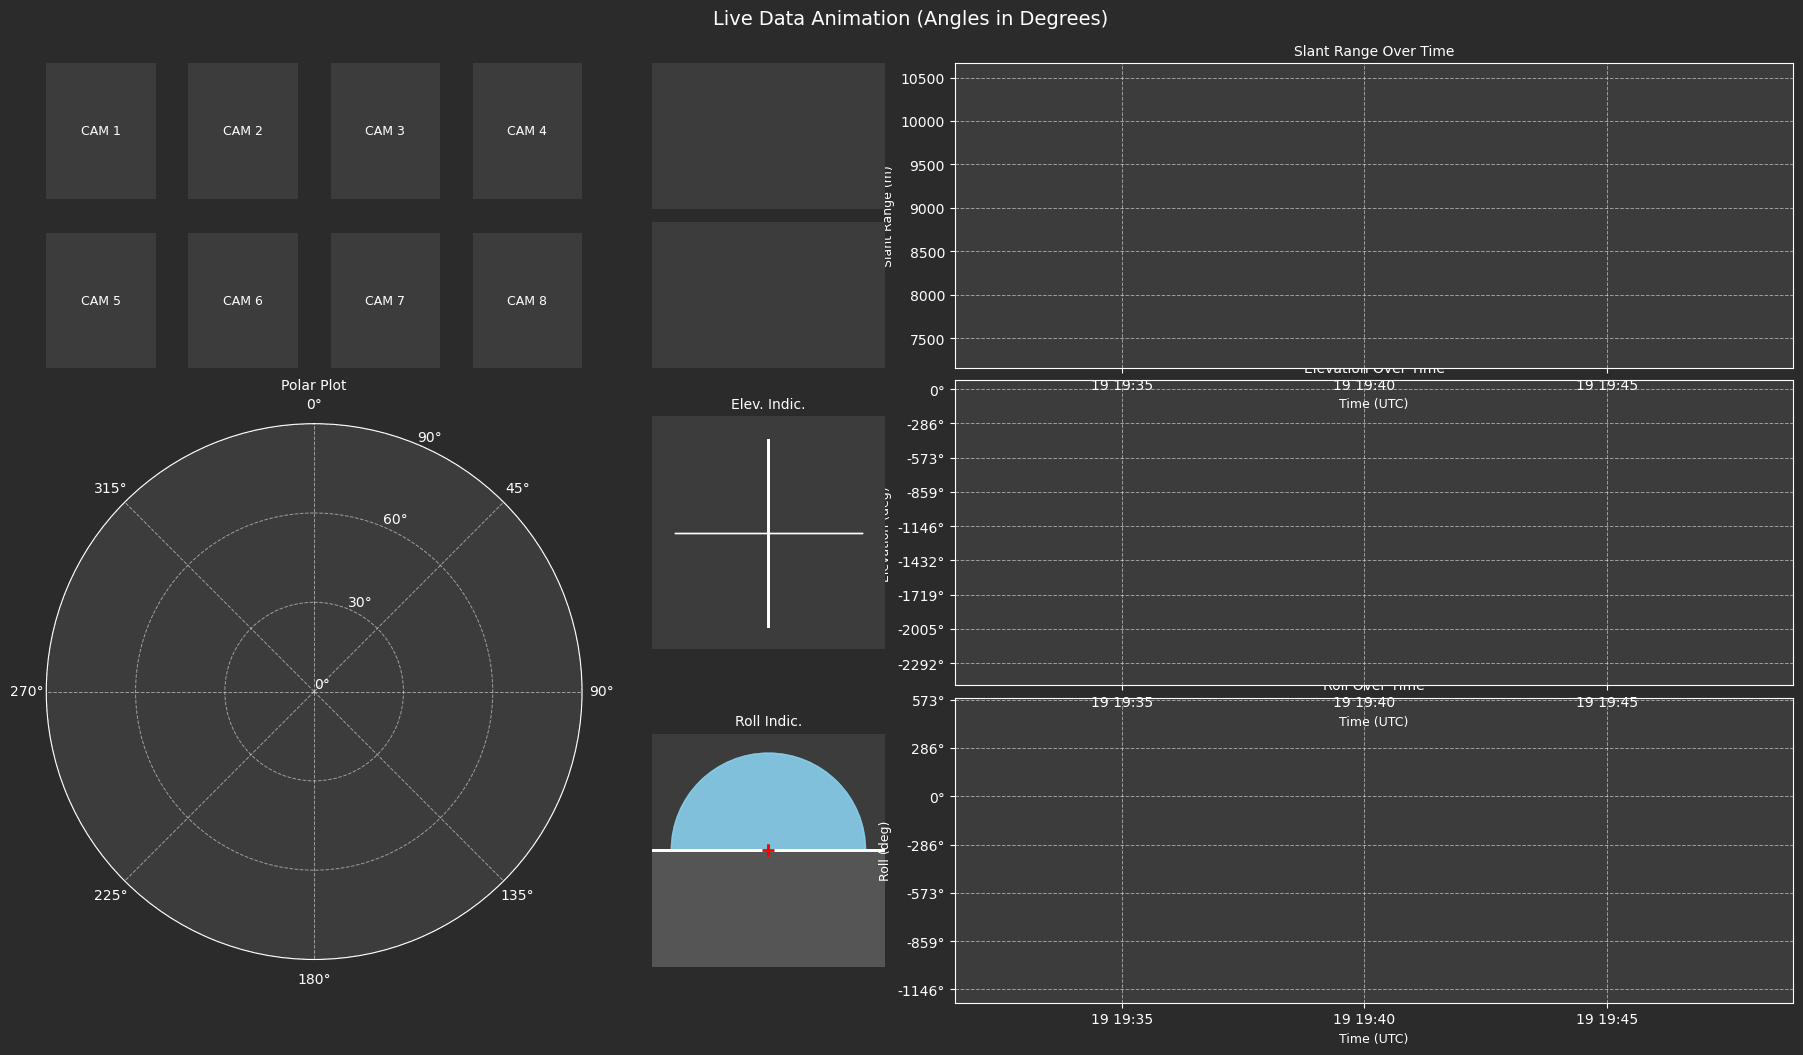

Saving animation as GIF (using Pillow)...
Init function completed.
Updating frame 50/374
Updating frame 100/374
Updating frame 150/374
Updating frame 200/374
Updating frame 250/374
Updating frame 300/374
Updating frame 350/374
Animation saved successfully as animation_dark.gif
Using Matplotlib backend: module://matplotlib_inline.backend_inline


In [4]:
import  matplotlib.pyplot      as      plt
import  matplotlib.gridspec    as      gridspec
import  numpy                  as      np
import  pandas                 as      pd
from    matplotlib.animation   import  FuncAnimation
from    matplotlib.transforms  import  Affine2D
import  matplotlib.ticker      as      mticker # Import ticker for formatting

# --- Style and rcParams ---
try:
    plt.style.use('dark_background')
    print("Matplotlib style set to 'dark_background'")
except Exception as e: print(f"Could not set style: {e}")

DARK_GREY_FIG = '#2B2B2B'; DARK_GREY_AX = '#3C3C3C'
try:
    plt.rcParams['figure.facecolor'] = DARK_GREY_FIG
    plt.rcParams['axes.facecolor'] = DARK_GREY_AX
    print(f"Overrode figure.facecolor to {DARK_GREY_FIG}")
    print(f"Overrode axes.facecolor to {DARK_GREY_AX}")
except Exception as e: print(f"Could not override rcParams: {e}")

# --- Configuration ---
FIG_WIDTH_PIXELS = 1920; FIG_HEIGHT_PIXELS = 1080; DPI = 100
FIG_WIDTH_INCHES = FIG_WIDTH_PIXELS / DPI; FIG_HEIGHT_INCHES = FIG_HEIGHT_PIXELS / DPI
MAIN_TITLE_FS = 14; SUBPLOT_TITLE_FS = 10; NUM_FS = 10; TEXT_FS = 9; TICK_LABEL_FS = 8
INDICATOR_YELLOW = '#FFFF00'; INDICATOR_SKY = 'skyblue'; INDICATOR_BASE = '#555555'; METER_BAR_COLOR = 'gold'
METERS_PER_NAUTICAL_MILE = 1852.0

# --- Helper Func ---
def style_indicator_ax(ax):
    ax.set_xticks([]); ax.set_yticks([]); ax.spines[:].set_visible(False)

# --- Degree Formatter ---
def rad_to_deg_fmt(x, pos):
    """Format radians tick value to degrees string."""
    return f'{np.degrees(x):.0f}\N{DEGREE SIGN}'

degree_formatter = mticker.FuncFormatter(rad_to_deg_fmt)

# --- !!! CONTROLLABLE SUBSAMPLING !!! ---
subsample_factor = 50

# --- Load and Prepare Data ---
try:
    df = pd.read_csv('vuefast.csv')
    print(f"Original data length: {len(df)}")
    dfn = df.iloc[::subsample_factor, :].copy()
    print(f"Subsampled data length (using factor {subsample_factor}): {len(dfn)}")
    if len(dfn) == 0: raise ValueError("Subsampling resulted in empty DataFrame.")

    # Selections (Angles are already in RADIANS)
    zulutime = pd.to_datetime(dfn['Zulu(UTC)'].copy())
    ac_roll = dfn['AcftInfo.ROL'].copy()
    ac_hdg = dfn['AcftInfo.HEA'].copy()
    pointer_az = dfn['WindowData.FdbckWRTAC.Az'].copy()
    pointer_el = dfn['WindowData.FdbckWRTAC.El'].copy()
    slr = dfn['CmdPointing.SlantRange'].copy()

    print("Data loaded and prepared successfully.")
    DATA_AVAILABLE = True
except FileNotFoundError: print("Error: vuefast.csv not found."); DATA_AVAILABLE = False
except KeyError as e: print(f"Error: Column {e} not found."); DATA_AVAILABLE = False
except ValueError as e: print(f"Error: {e}"); DATA_AVAILABLE = False
except Exception as e: print(f"An unexpected error occurred: {e}"); DATA_AVAILABLE = False

# --- Create Figure and Axes ---
fig = plt.figure(figsize=(FIG_WIDTH_INCHES, FIG_HEIGHT_INCHES), dpi=DPI)
fig.suptitle("Live Data Animation (Angles in Degrees)", fontsize=MAIN_TITLE_FS)
gs_main = gridspec.GridSpec(24, 6, figure=fig)
# (Axes creation code...)
ax_polar = fig.add_subplot(gs_main[8:24, 0:2], projection='polar')
ax_roll_ind = fig.add_subplot(gs_main[16:24, 2]); style_indicator_ax(ax_roll_ind)
ax_roll_time = fig.add_subplot(gs_main[16:24, 3:6])
ax_elev_time = fig.add_subplot(gs_main[8:16, 3:6])
ax_elev_ind = fig.add_subplot(gs_main[8:16, 2]); style_indicator_ax(ax_elev_ind)
ax_slant_plot = fig.add_subplot(gs_main[0:8, 3:6])
ax_slant_num_top = fig.add_subplot(gs_main[0:4, 2]); style_indicator_ax(ax_slant_num_top)
ax_slant_num_bot = fig.add_subplot(gs_main[4:8, 2]); style_indicator_ax(ax_slant_num_bot)
camera_settings_spec = gs_main[0:8, 0:2]
gs_cam_nested = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=camera_settings_spec, wspace=0.3, hspace=0.25)
cam_axes = []
for r in range(2):
    for c in range(4):
        ax = fig.add_subplot(gs_cam_nested[r, c]); style_indicator_ax(ax)
        ax.text(0.5, 0.5, f'CAM {r*4+c+1}', ha='center', va='center', fontsize=TEXT_FS)
        cam_axes.append(ax)

# --- Declare Artist Variables Globally ---
line_polar_pointer = None; roll_horizon = None; line_roll_time = None;
line_elev_time = None; elev_line = None; line_slant_plot = None;
text_slant_num_top = None; text_slant_num_bot = None;
roll_center_marker = None; # For debugging pivot

# --- Animation Init Function ---
def init():
    global line_polar_pointer, roll_horizon, line_roll_time, line_elev_time, \
           elev_line, line_slant_plot, text_slant_num_top, text_slant_num_bot, \
           roll_center_marker
    artists = []
    if not DATA_AVAILABLE: return artists

    # 1. Polar Plot Setup (Labels already in degrees)
    ax_polar.set_title('Polar Plot', fontsize=SUBPLOT_TITLE_FS)
    ax_polar.set_theta_zero_location('N'); ax_polar.set_theta_direction(-1)
    max_el_rad = np.pi / 2
    ax_polar.set_rlim(0, max_el_rad)
    rticks_rad = np.linspace(0, max_el_rad, 4)
    rticks_deg_labels = [f"{np.degrees(r):.0f}\N{DEGREE SIGN}" for r in rticks_rad]
    ax_polar.set_rticks(rticks_rad); ax_polar.set_yticklabels(rticks_deg_labels)
    ax_polar.grid(True, linestyle='--', alpha=0.5, linewidth=0.7)
    line_polar_pointer, = ax_polar.plot([], [], 'o-', color=INDICATOR_YELLOW, markersize=5, lw=1.5)
    artists.append(line_polar_pointer)

    # 2. Roll Indicator Setup (Ensure aspect ratio, add center marker)
    ax_roll_ind.set_title('Roll Indic.', fontsize=SUBPLOT_TITLE_FS)
    ax_roll_ind.set_aspect('equal', adjustable='box') # Ensure circle looks circular
    ax_roll_ind.set_xlim(-1.2, 1.2); ax_roll_ind.set_ylim(-1.2, 1.2)
    roll_horizon, = ax_roll_ind.plot([-1.2, 1.2], [0, 0], color=plt.rcParams['text.color'], lw=2)
    # Add marker at center (0,0) to check pivot
    roll_center_marker, = ax_roll_ind.plot(0, 0, '+', color='red', markersize=8, markeredgewidth=2)
    artists.append(roll_horizon)
    artists.append(roll_center_marker) # Add marker to artists (though it doesn't change)
    # Static background elements
    circle = plt.Circle((0, 0), 1.0, color=INDICATOR_SKY, fill=True, alpha=0.7, zorder=0); ax_roll_ind.add_patch(circle)
    base = plt.Rectangle((-1.2, -1.2), 2.4, 1.2, color=INDICATOR_BASE, fill=True, zorder=0); ax_roll_ind.add_patch(base)

    # 3. Roll Over Time Setup (Label uses Degrees)
    ax_roll_time.set_title('Roll Over Time', fontsize=SUBPLOT_TITLE_FS)
    ax_roll_time.set_xlabel("Time (UTC)", fontsize=TEXT_FS); ax_roll_time.set_ylabel("Roll (deg)", fontsize=TEXT_FS) # Label updated
    # Apply degree formatter to Y axis
    ax_roll_time.yaxis.set_major_formatter(degree_formatter)
    if not zulutime.empty: ax_roll_time.set_xlim(zulutime.min(), zulutime.max())
    # Set Y limits in degrees now
    if not ac_roll.empty: ax_roll_time.set_ylim(np.degrees(ac_roll.min()) - 10, np.degrees(ac_roll.max()) + 10)
    ax_roll_time.grid(True, linestyle='--', alpha=0.5, linewidth=0.7)
    line_roll_time, = ax_roll_time.plot([], [], lw=1.5)
    artists.append(line_roll_time)

    # 4. Elevation Over Time Setup (Label uses Degrees)
    ax_elev_time.set_title('Elevation Over Time', fontsize=SUBPLOT_TITLE_FS)
    ax_elev_time.set_xlabel("Time (UTC)", fontsize=TEXT_FS); ax_elev_time.set_ylabel("Elevation (deg)", fontsize=TEXT_FS) # Label updated
    # Apply degree formatter to Y axis
    ax_elev_time.yaxis.set_major_formatter(degree_formatter)
    if not zulutime.empty: ax_elev_time.set_xlim(zulutime.min(), zulutime.max())
    # Set Y limits in degrees now
    if not pointer_el.empty: ax_elev_time.set_ylim(np.degrees(pointer_el.min()) - 10, np.degrees(pointer_el.max()) + 10)
    ax_elev_time.grid(True, linestyle='--', alpha=0.5, linewidth=0.7)
    line_elev_time, = ax_elev_time.plot([], [], lw=1.5)
    artists.append(line_elev_time)

    # 5. Elevation Indicator Setup
    ax_elev_ind.set_title('Elev. Indic.', fontsize=SUBPLOT_TITLE_FS)
    ax_elev_ind.set_aspect('equal', adjustable='box'); ax_elev_ind.set_xlim(-1, 1); ax_elev_ind.set_ylim(-1, 1)
    text_color = plt.rcParams['text.color']
    ax_elev_ind.plot([0, 0], [-0.8, 0.8], color=text_color, lw=2); ax_elev_ind.plot([-0.8, 0.8], [0, 0], color=text_color, lw=1)
    elev_line, = ax_elev_ind.plot([], [], color=INDICATOR_YELLOW, lw=2.5)
    artists.append(elev_line)

    # 6. Slant Range Plot Setup
    ax_slant_plot.set_title('Slant Range Over Time', fontsize=SUBPLOT_TITLE_FS)
    ax_slant_plot.set_xlabel("Time (UTC)", fontsize=TEXT_FS); ax_slant_plot.set_ylabel("Slant Range (m)", fontsize=TEXT_FS)
    if not zulutime.empty: ax_slant_plot.set_xlim(zulutime.min(), zulutime.max())
    if not slr.empty: ax_slant_plot.set_ylim(slr.min() * 0.95, slr.max() * 1.05)
    ax_slant_plot.grid(True, linestyle='--', alpha=0.5, linewidth=0.7)
    line_slant_plot, = ax_slant_plot.plot([], [], lw=1.5)
    artists.append(line_slant_plot)

    # 7. Slant Range Numbers Setup (m and NM)
    text_slant_num_top = ax_slant_num_top.text(0.5, 0.5, "", ha='center', va='center', fontsize=NUM_FS + 1)
    artists.append(text_slant_num_top)
    text_slant_num_bot = ax_slant_num_bot.text(0.5, 0.5, "", ha='center', va='center', fontsize=NUM_FS + 1)
    artists.append(text_slant_num_bot)

    print("Init function completed.")
    return artists

# --- Animation Update Function ---
def update(frame):
    artists = []
    if not DATA_AVAILABLE: return artists

    current_time = zulutime.iloc[frame]; current_roll = ac_roll.iloc[frame]
    current_hdg = ac_hdg.iloc[frame]; current_az = pointer_az.iloc[frame]
    current_el = pointer_el.iloc[frame]; current_slr = slr.iloc[frame]

    # 1. Update Polar Plot
    if line_polar_pointer is not None:
        radius = current_el # Plot radius using raw radians (matches axis lims)
        line_polar_pointer.set_data([current_az], [radius]) # Az is radians
        artists.append(line_polar_pointer)

    # 2. Update Roll Indicator
    if roll_horizon is not None:
        rotation = Affine2D().rotate_around(0, 0, -current_roll) # Use radians
        roll_horizon.set_transform(ax_roll_ind.transData + rotation)
        artists.append(roll_horizon)
    # The center marker doesn't need updating, but must be in returned list if blit=True
    if roll_center_marker is not None: artists.append(roll_center_marker)


    # 3. Update Roll Over Time Plot (Data is radians)
    if line_roll_time is not None:
        # Plotting still uses radian values, formatter handles display
        line_roll_time.set_data(zulutime.iloc[:frame+1], ac_roll.iloc[:frame+1])
        artists.append(line_roll_time)

    # 4. Update Elevation Over Time Plot (Data is radians)
    if line_elev_time is not None:
        # Plotting still uses radian values, formatter handles display
        line_elev_time.set_data(zulutime.iloc[:frame+1], pointer_el.iloc[:frame+1])
        artists.append(line_elev_time)

    # 5. Update Elevation Indicator (Use radians)
    if elev_line is not None:
        el_angle_to_plot = current_el
        el_line_len = 0.8
        el_line_x = [0, el_line_len * np.cos(el_angle_to_plot)] # X = cos for angle from Y=0?
        el_line_y = [0, el_line_len * np.sin(el_angle_to_plot)] # Y = sin
        elev_line.set_data(el_line_x, el_line_y)
        artists.append(elev_line)

    # 6. Update Slant Range Plot
    if line_slant_plot is not None:
        line_slant_plot.set_data(zulutime.iloc[:frame+1], slr.iloc[:frame+1])
        artists.append(line_slant_plot)

    # 7. Update Slant Range Numbers (m and NM)
    if text_slant_num_top is not None:
        text_slant_num_top.set_text(f"{current_slr:.0f} m")
        artists.append(text_slant_num_top)
    if text_slant_num_bot is not None:
        current_slr_nm = current_slr / METERS_PER_NAUTICAL_MILE
        text_slant_num_bot.set_text(f"{current_slr_nm:.2f} NM")
        artists.append(text_slant_num_bot)

    if frame > 0 and frame % 50 == 0: print(f"Updating frame {frame}/{len(dfn)}")

    return artists

# --- Create and Run Animation ---
# (Animation creation, saving, and display code remains the same)
if DATA_AVAILABLE:
    num_frames = len(dfn)
    anim_interval = 100
    anim_fps = 1000 / anim_interval

    print(f"Creating Animation object with {num_frames} frames...")
    ani = FuncAnimation(fig, update, frames=num_frames,
                        init_func=init, blit=True, interval=anim_interval,
                        repeat=False)

    fig.subplots_adjust(left=0.05, right=0.96, top=0.93, bottom=0.06,
                        wspace=0.30, hspace=0.45) # Increased hspace slightly

    print("Displaying animation...")
    plt.show()

    try:
        print("Saving animation as GIF (using Pillow)...")
        ani.save('animation_dark.gif', writer='pillow', fps=anim_fps, dpi=100)
        print("Animation saved successfully as animation_dark.gif")
    except Exception as e:
        print(f"Error saving animation: {e}")
        print("Ensure Pillow is installed (`pip install Pillow`)")

else:
    print("Cannot create animation due to data loading errors.")
    fig.subplots_adjust(left=0.05, right=0.96, top=0.93, bottom=0.06, wspace=0.30, hspace=0.45)
    plt.show()

import matplotlib
print(f"Using Matplotlib backend: {matplotlib.get_backend()}")